In [1]:
from functools import partial, reduce
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from tqdm import trange

In [2]:
df = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv",
    sep=",",
)
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
# Do not modify
df = df.drop(["cbwd"], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how="any")  # drop samples who has nan feature
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0


In [4]:
# Do not modify
idx = np.logical_or(
    np.logical_and(df["year"].values == 2014, df["month"].values < 3),
    np.logical_and(df["year"].values == 2013, df["month"].values == 12),
)
X = df.loc[idx].drop("pm2.5", axis=1)
y = df.loc[idx]["pm2.5"].values
X.head()

,No,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir
34320,34321,2013,12,1,0,-13,-2.0,1026.0,0.89,0,0
34321,34322,2013,12,1,1,-14,-3.0,1025.0,3.13,0,0
34322,34323,2013,12,1,2,-13,-3.0,1025.0,0.89,0,0
34323,34324,2013,12,1,3,-13,-4.0,1025.0,0.89,0,0
34324,34325,2013,12,1,4,-13,-3.0,1025.0,1.78,0,0


In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Linear regression

In [6]:
class PolynomialFeatures:
    def __init__(self, degree=2):
        self.degree = degree

    def fit(self, X):
        return self

    def transform(self, X):
        _, n_features = X.shape
        x_powered = np.concatenate(
            [np.power(X, i) for i in range(1, self.degree + 1)], axis=-1
        )

        x_combination = [
            np.prod(X[:, c], axis=1)
            for d in np.arange(1, self.degree)
            for c in combinations(range(n_features), d + 1)
        ]
        x_combination = np.stack(x_combination, axis=-1)

        return np.concatenate([x_powered, x_combination], axis=-1)

    def fit_transform(self, X):
        return self.fit(X).transform(X)


class LinearRegressor(object):
    def __init__(self, eta, n_iter, random_state):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def net_input(self, X):
        return X @ self.w_[1:] + self.w_[0]

    def _partial_fit(self, X, y):
        output = self.net_input(X)
        error = y - output

        self.w_[1:] += self.eta * X.T @ error
        self.w_[0] += self.eta * np.sum(error)

        return np.sum(error**2) / len(error)

    def fit(self, X, y, batch_size=1):
        self.w_ = np.random.RandomState(self.random_state).normal(
            0, 0.01, size=X.shape[1] + 1
        )
        self.cost_ = []

        pbar = trange(self.n_iter, desc="Epochs")
        for _ in pbar:
            cost = [
                self._partial_fit(X[i : i + batch_size], y[i : i + batch_size])
                for i in range(0, len(X), batch_size)
            ]
            pbar.set_postfix(cost=np.mean(cost))
            self.cost_.append(np.mean(cost))

        return self

    def predict(self, X):
        return self.net_input(X)

    def plot_loss(self):
        plt.plot(np.arange(len(self.cost_)), self.cost_)
        plt.ylabel("Cost")
        plt.xlabel("Epochs")
        plt.tight_layout()
        plt.show()

In [7]:
scaler = StandardScaler()
normalizer = Normalizer()
preprocessor = partial(
    reduce,
    lambda X, f: f.fit_transform(X),
    [scaler, normalizer],
)

regressor = LinearRegressor(eta=0.0009, n_iter=1000, random_state=0)

for degree in range(2, 16, 3):
    poly = PolynomialFeatures(degree=degree)

    x_train_poly = poly.fit_transform(preprocessor(x_train))
    x_test_poly = poly.transform(preprocessor(x_test))

    regressor = regressor.fit(x_train_poly, y_train)
    y_train_pred = regressor.predict(x_train_poly)
    y_test_pred = regressor.predict(x_test_poly)

    r2_train_score = r2_score(y_train, y_train_pred)
    r2_test_score = r2_score(y_test, y_test_pred)

    print(f"Degree: {degree}, r2 score", end=" | ")
    print(f"Train: {r2_train_score:.2f} | Test: {r2_test_score:.2f}")

Epochs:   1%|          | 10/1000 [00:00<00:10, 92.88it/s, cost=7.69e+3]

Epochs: 100%|██████████| 1000/1000 [00:10<00:00, 94.01it/s, cost=5.24e+3]


Degree: 2, r2 score | Train: 0.67 | Test: 0.60


Epochs: 100%|██████████| 1000/1000 [00:14<00:00, 70.63it/s, cost=4.55e+3]


Degree: 5, r2 score | Train: 0.71 | Test: 0.65


Epochs: 100%|██████████| 1000/1000 [00:17<00:00, 57.42it/s, cost=4.51e+3]


Degree: 8, r2 score | Train: 0.71 | Test: 0.65


Epochs: 100%|██████████| 1000/1000 [00:17<00:00, 56.18it/s, cost=4.51e+3]


Degree: 11, r2 score | Train: 0.71 | Test: 0.65


Epochs: 100%|██████████| 1000/1000 [00:17<00:00, 55.67it/s, cost=4.51e+3]


Degree: 14, r2 score | Train: 0.71 | Test: 0.65


Epochs:   0%|          | 0/10000 [00:00<?, ?it/s, cost=7.31e+3]

Epochs: 100%|██████████| 10000/10000 [00:40<00:00, 244.16it/s, cost=3.81e+3]


R2 score | train: 0.76 | test: 0.69


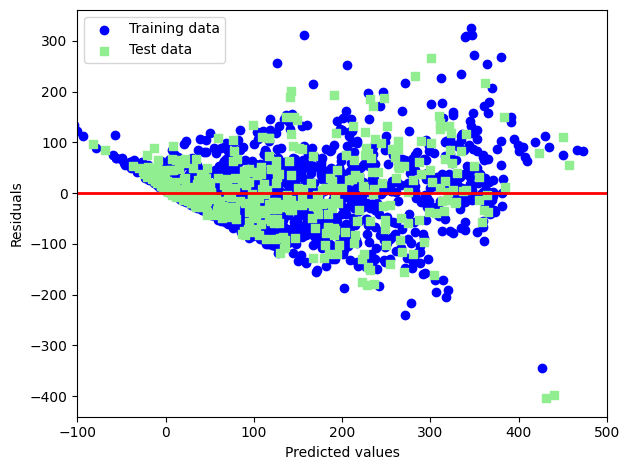

In [8]:
# Train
scaler = StandardScaler()
normalizer = Normalizer()
poly = PolynomialFeatures(degree=8)
regressor = LinearRegressor(eta=0.0009, n_iter=10000, random_state=0)

preprocessor = partial(
    reduce,
    lambda X, f: f.fit_transform(X),
    [scaler, normalizer, poly],
)

x_train_poly = preprocessor(x_train.to_numpy())
regressor = regressor.fit(x_train_poly, y_train, batch_size=64)

y_train_pred = regressor.predict(x_train_poly)
r2_train = r2_score(y_train, y_train_pred)

# Test
x_test_poly = preprocessor(x_test.to_numpy())
y_test_pred = regressor.predict(x_test_poly)
r2_test = r2_score(y_test, y_test_pred)
print(f"R2 score | train: {r2_train:.2f} | test: {r2_test:.2f}")

# Residual plot
residual_train = y_train - y_train_pred
residual_test = y_test - y_test_pred

plt.scatter(y_train_pred, residual_train, c="blue", marker="o", label="Training data")
plt.scatter(y_test_pred, residual_test, c="lightgreen", marker="s", label="Test data")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=-100, xmax=500, lw=2, color="red")
plt.xlim([-100, 500])
plt.tight_layout()
plt.show()

## Random Forest Regressor

R2 score | train: 0.98 | test: 0.96


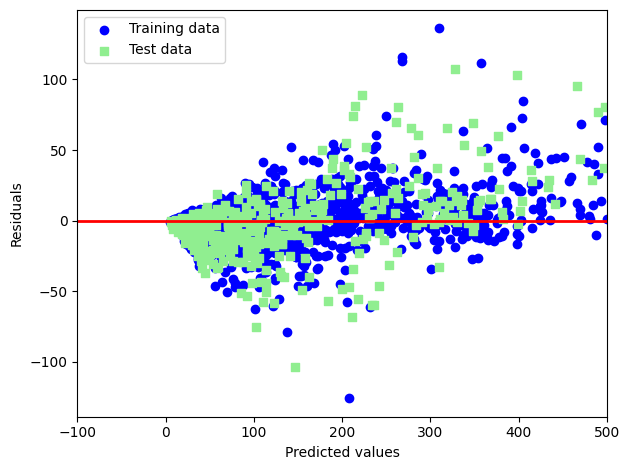

In [11]:
x_train_std = preprocessor(x_train.to_numpy())
x_test_std = preprocessor(x_test.to_numpy())

forest = RandomForestRegressor(
    n_estimators=1000, criterion="squared_error", random_state=1, n_jobs=-1
)
forest.fit(x_train_std, y_train)
y_train_pred = forest.predict(x_train_std)

forest.fit(x_test_std, y_test)
y_test_pred = forest.predict(x_test_std)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R2 score | train: {r2_train:.2f} | test: {r2_test:.2f}")

# Residual plot
residual_train = y_train - y_train_pred
residual_test = y_test - y_test_pred

plt.scatter(y_train_pred, residual_train, c="blue", marker="o", label="Training data")
plt.scatter(y_test_pred, residual_test, c="lightgreen", marker="s", label="Test data")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=-100, xmax=500, lw=2, color="red")
plt.xlim([-100, 500])
plt.tight_layout()
plt.show()